# AAS Project - Kubernetes Attack Cluster

descricao

## useful links

https://blog.palark.com/kubernetes-services-interaction-monitoring-with-netflow/

#### Imports


In [2]:
import pandas as pd
import hopsworks
import hsfs
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

fg = fs.get_feature_group('benign_and_malicious_traffic_february', version=1)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/75925
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
#! na net da ua nao consigo ir buscar os dados à feature store, portanto tenho de os ir buscar localmente (:( firewall da ua so causa problemas)
data = pd.read_csv('data.csv')

#### Read data from Feature Store

In [12]:
data = fg.read()

Finished: Reading data from Hopsworks, using ArrowFlight (13.06s) 


### Get a small sample of data

In [5]:
data.head(-1)


,source_flow_id_encoded,source_flow_final,source_source_ip,source_destination_ip,source_network_bytes,source_network_transport,source_timestamp,source_event_duration,source_destination_port,source_source_port,label
0,44376,0,3201805056,3201768135,14350,1,1645795940002,1238779,13431.0,80.0,benign
1,10424,0,905919982,3201805059,356,1,1645796270003,388466020,22.0,55735.0,malicious
2,16823,0,2130759677,2130759677,863,1,1645793070013,421875,9099.0,52024.0,benign
3,42693,0,3201805056,3201805058,39848,1,1645794750091,396938798,3306.0,43230.0,benign
4,44368,0,3201768135,3201805056,224,1,1645794150001,137565,80.0,28789.0,benign
...,...,...,...,...,...,...,...,...,...,...,...
47361,31885,1,4027662305,4027632616,68,1,1645796693657,0,31301.0,60985.0,malicious
47362,2685,0,3201805056,3201768134,547,2,1645795850001,149470,53.0,48479.0,benign
47363,33961,1,4027662305,4027632616,68,1,1645796500321,0,31301.0,47449.0,malicious
47364,37,1,3201805072,901724183,272,2,1645791610001,300784,53.0,42206.0,benign


In [6]:
data.describe()


,source_flow_id_encoded,source_flow_final,source_source_ip,source_destination_ip,source_network_bytes,source_network_transport,source_timestamp,source_event_duration,source_destination_port,source_source_port
count,47367.000000,47367.000000,4.736700e+04,4.736700e+04,4.736700e+04,47367.000000,4.736700e+04,4.736700e+04,47367.000000,47367.000000
mean,23689.249161,0.468026,3.830171e+17,3.830171e+17,1.763886e+05,1.074102,1.645796e+12,2.375082e+10,17907.334558,43939.324403
std,13674.233126,0.498982,1.840130e+18,1.840130e+18,1.182142e+07,0.261940,1.294159e+06,3.693959e+11,14371.276207,13379.243218
min,6.000000,0.000000,8.751053e+07,8.712241e+07,5.600000e+01,1.000000,1.645792e+12,0.000000e+00,22.000000,22.000000
25%,11847.500000,0.000000,9.059200e+08,3.201805e+09,6.800000e+01,1.000000,1.645796e+12,0.000000e+00,3306.000000,38002.000000
50%,23689.000000,0.000000,4.027633e+09,4.027633e+09,1.720000e+02,1.000000,1.645797e+12,1.197990e+05,9500.000000,45864.000000
75%,35530.500000,1.000000,4.027662e+09,4.027633e+09,4.330000e+02,1.000000,1.645797e+12,2.522046e+06,31301.000000,53576.500000
max,47378.000000,1.000000,9.223372e+18,9.223372e+18,1.828469e+09,2.000000,1.645798e+12,6.601664e+12,65522.000000,65523.000000


## Data Visualization

#### Data Distribution

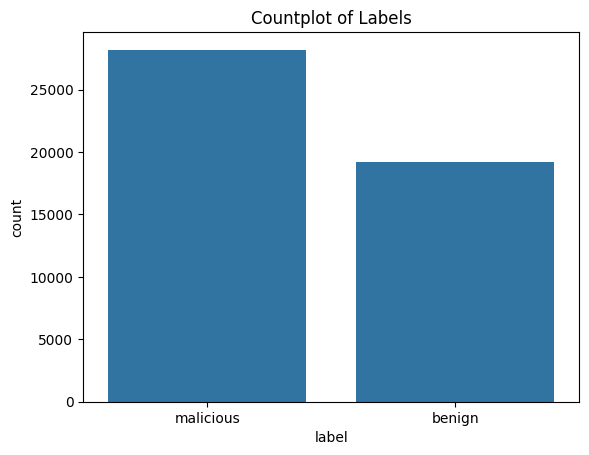

In [13]:
sns.countplot(x='label', data=data)
plt.title('Data Distribution')
plt.show()

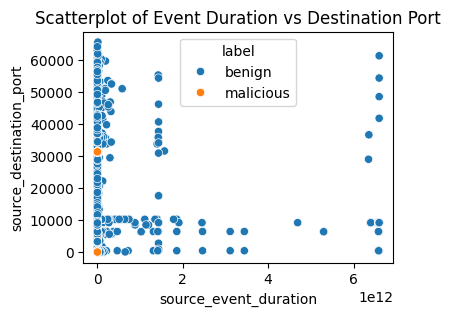

In [7]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='source_event_duration', y='source_destination_port', hue='label', data=data)
plt.title('Event Duration vs Destination Port')
plt.show()

##### With this plot (and the following) we can observate that malicious traffic tend to a small duration that the benign traffic.

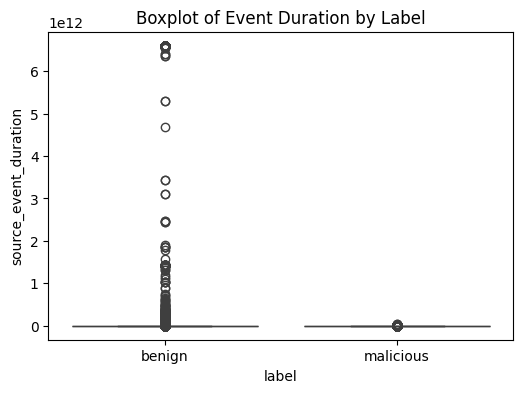

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='source_event_duration', data=data)
plt.title('Duration by Label')
plt.show()

#### Pair plot 

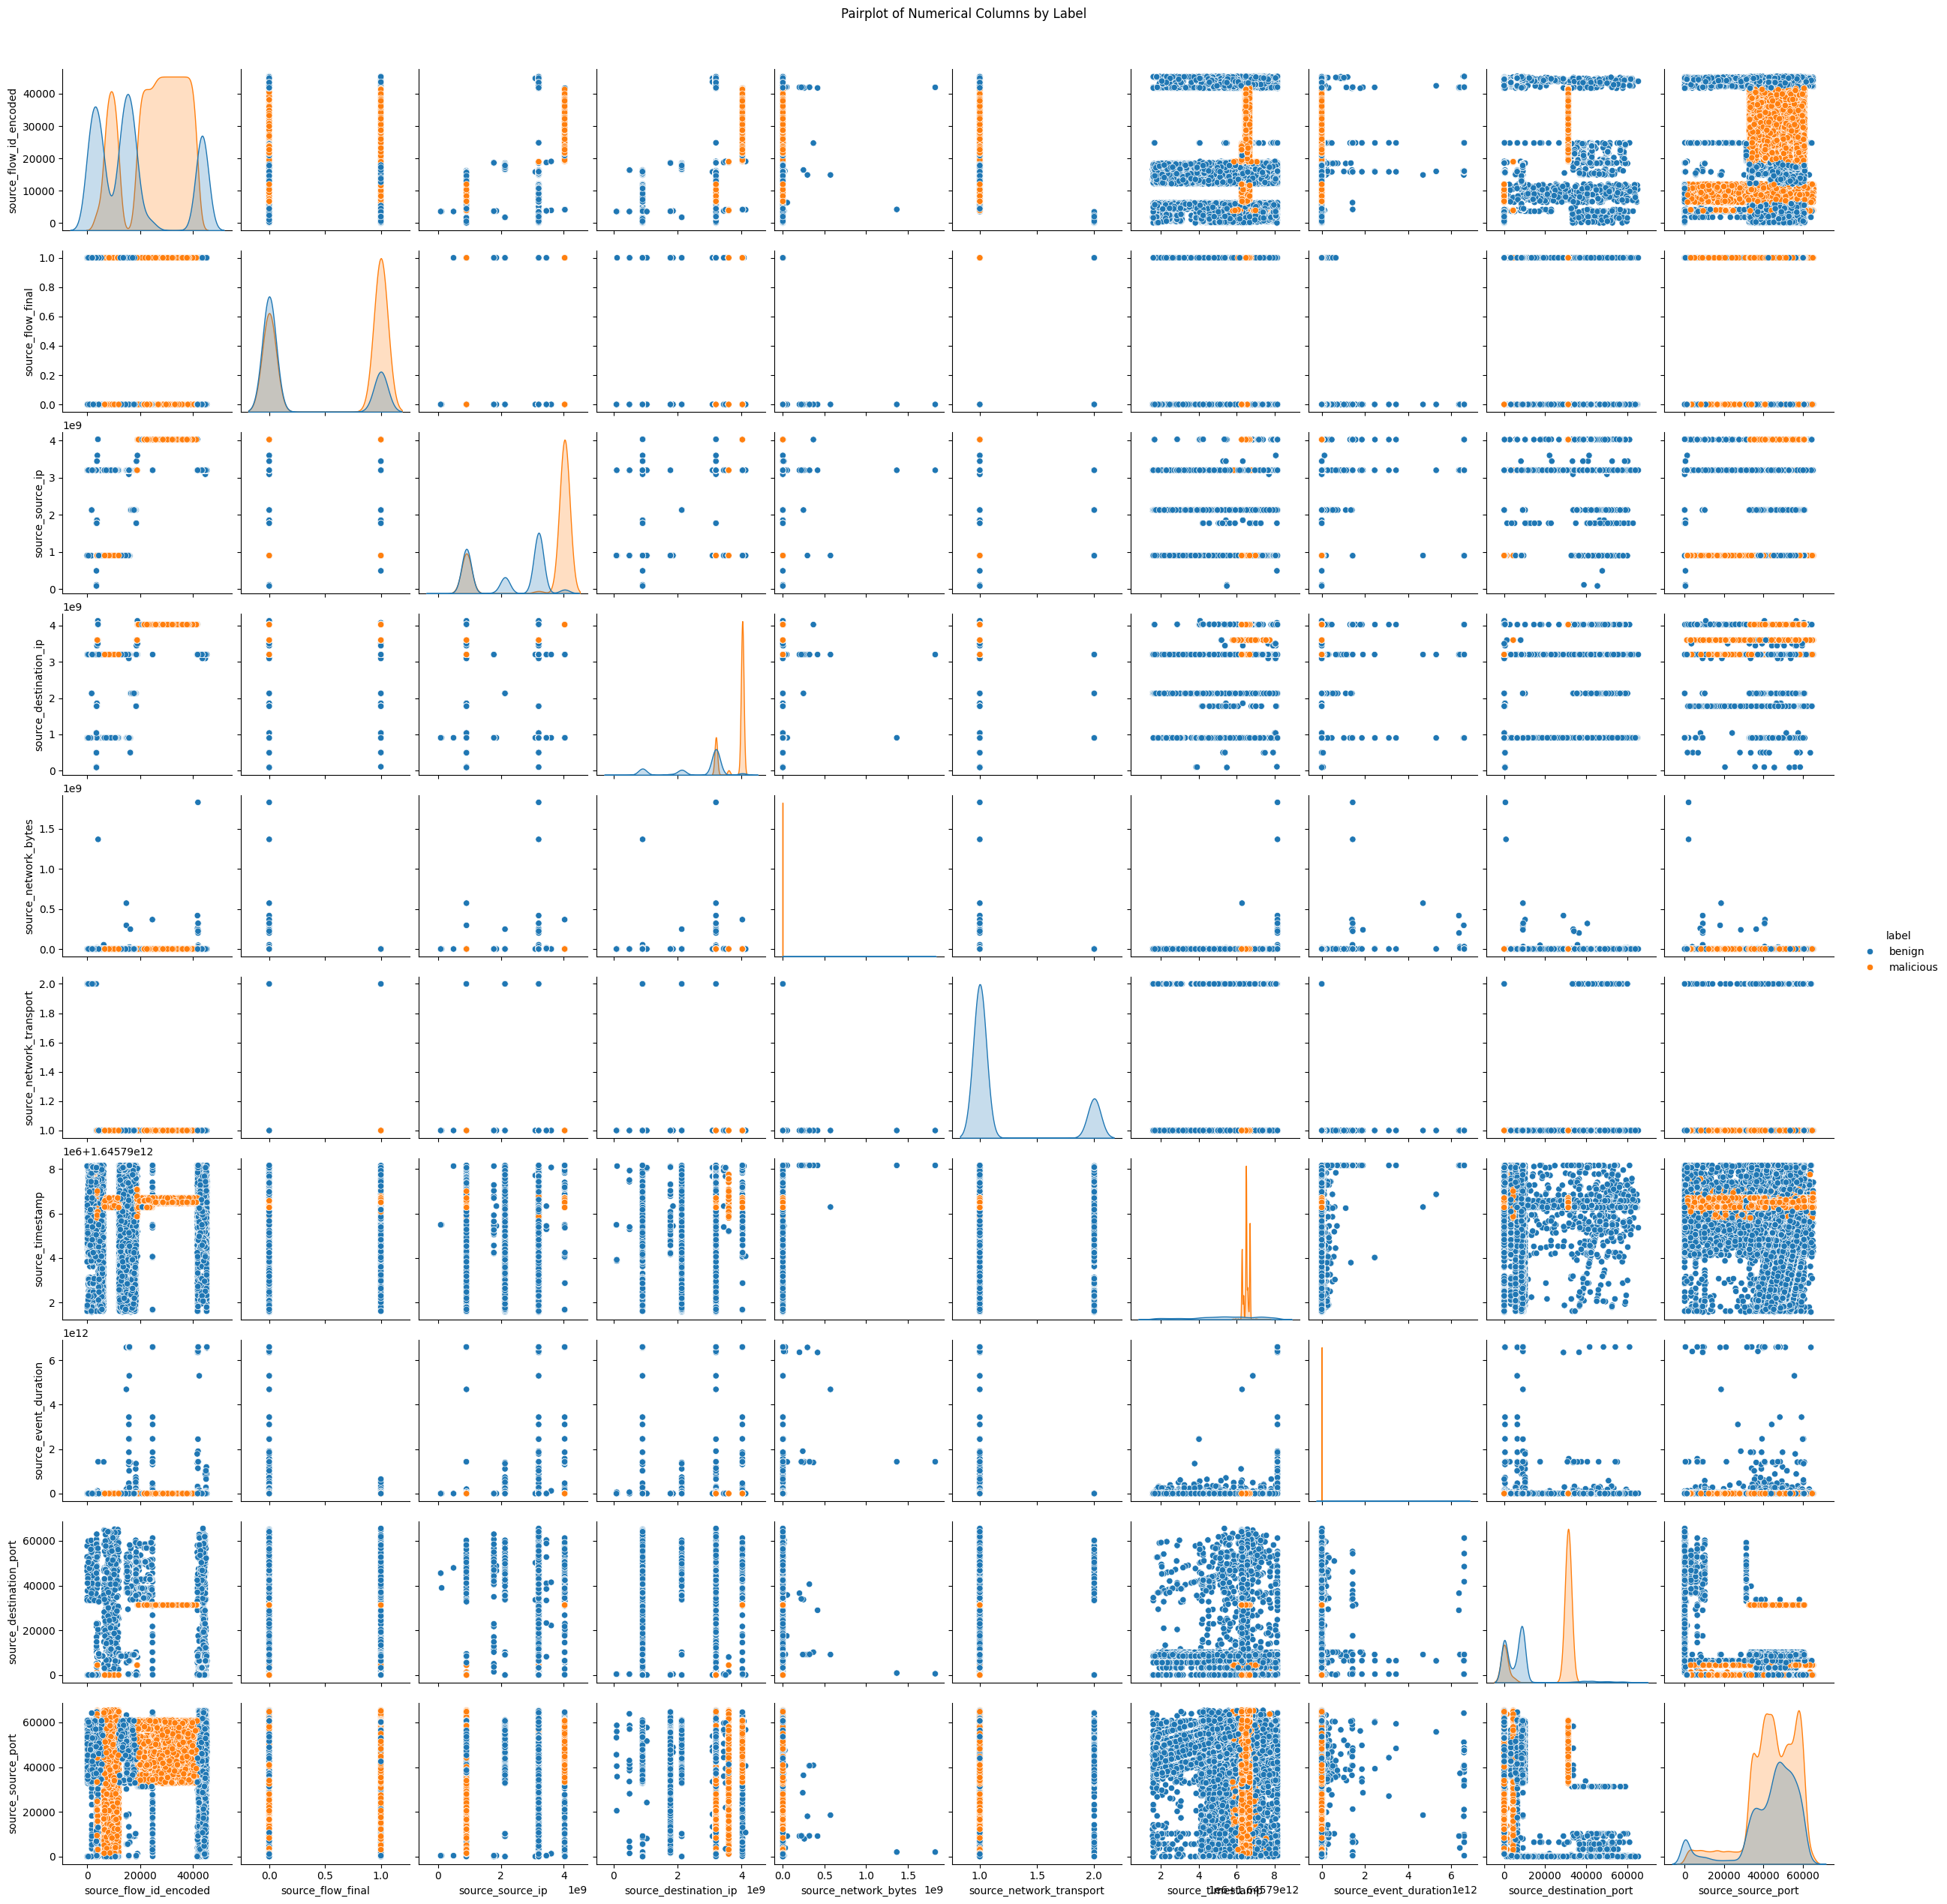

In [9]:
sns.pairplot(data, hue='label')
plt.suptitle('Pairplot of Numerical Columns by Label', y=1.02)
plt.show()

#### Histograms for each feature (hue = label)

In [ ]:
features = data.columns
n_rows = (len(features) + 2) // 3

fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(data=data, x=feature, hue='label', kde=True, bins=20, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')

for i in range(len(features), n_rows * 3):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

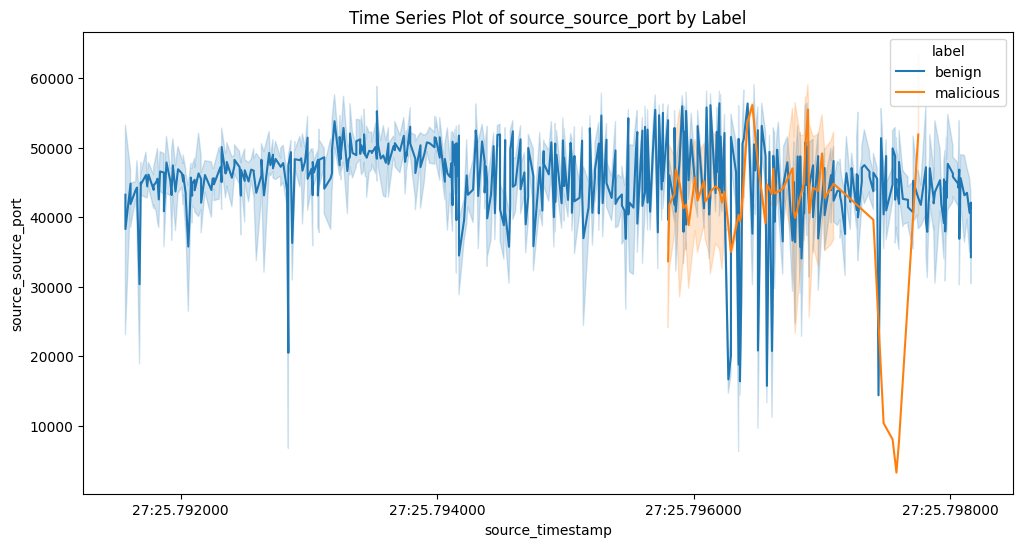

In [11]:
data['source_timestamp'] = pd.to_datetime(data['source_timestamp'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='source_timestamp', y='source_source_port', hue='label', data=data)
plt.title('Time Series Plot of source_source_port by Label')
plt.show()

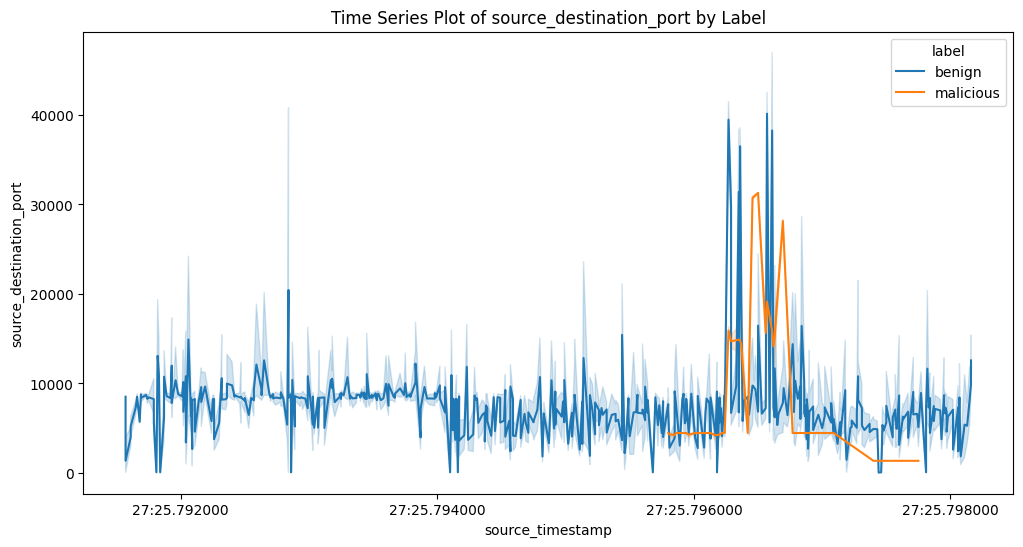

In [12]:
data['source_timestamp'] = pd.to_datetime(data['source_timestamp'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='source_timestamp', y='source_flow_id_encoded', hue='label', data=data)
plt.title('source_destination_port by Label (Per timestamp)')
plt.show()

In [5]:
fv = fs.get_feature_view('benign_and_malicious_traffic_february_view', version=1)

#### The data is split into train, validation and test sets, this was made in the pre-processing phase (folder feature-store in the root of the project)

In [6]:
x_train, x_test, _, y_train, y_test, __= fv.get_train_validation_test_split(training_dataset_version=3)

#### Init Models

In [7]:
svc = SVC(random_state=42)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)


pipeline_svc = Pipeline(steps=[('classifier', svc)])
pipeline_lr = Pipeline(steps=[('classifier', lr)])
pipeline_knn = Pipeline(steps=[('classifier', knn)])
pipeline_dt = Pipeline(steps=[('classifier', dt)])

#### Select hyperparameters search for each model

In [8]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

In [9]:
model_grids = [
    (pipeline_svc, param_grid_svc, 'SVM'),
    (pipeline_lr, param_grid_lr, 'Logistic Regression'),
    (pipeline_knn, param_grid_knn, 'K-Nearest Neighbors'),
    (pipeline_dt, param_grid_dt, 'Decision Tree')
]

results = {
    "Model": [],
    "Default Accuracy": [],
    "Best Accuracy": [],
    "Best Parameters": []
}

### Train models with default and hyperparameters search and plot results and confusion matrix


SVM Evaluation:
Default parameters accuracy: 0.9743697478991596

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97      1911
   Malicious       0.97      0.99      0.98      2849

    accuracy                           0.97      4760
   macro avg       0.98      0.97      0.97      4760
weighted avg       0.97      0.97      0.97      4760



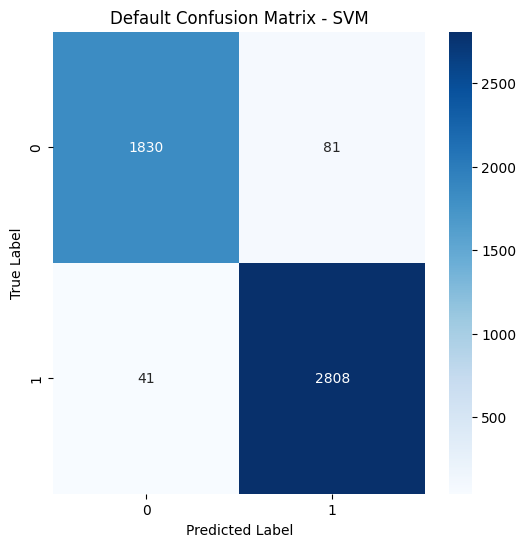

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/

Default parameters accuracy: 0.9783613445378151

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97      1911
   Malicious       0.98      0.99      0.98      2849

    accuracy                           0.98      4760
   macro avg       0.98      0.98      0.98      4760
weighted avg       0.98      0.98      0.98      4760



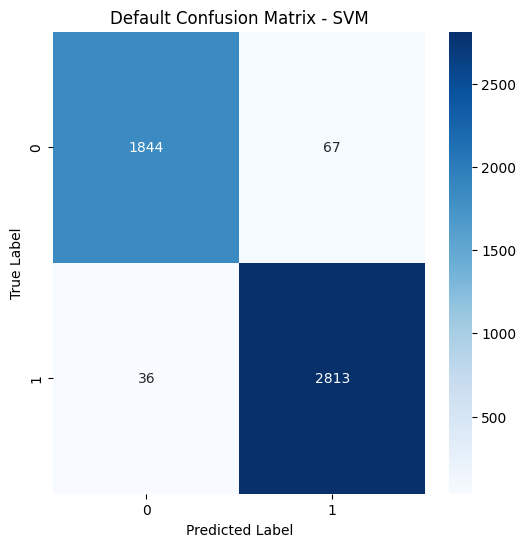


Logistic Regression Evaluation:
Default parameters accuracy: 0.8067226890756303

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.74      0.75      1911
   Malicious       0.83      0.85      0.84      2849

    accuracy                           0.81      4760
   macro avg       0.80      0.80      0.80      4760
weighted avg       0.81      0.81      0.81      4760



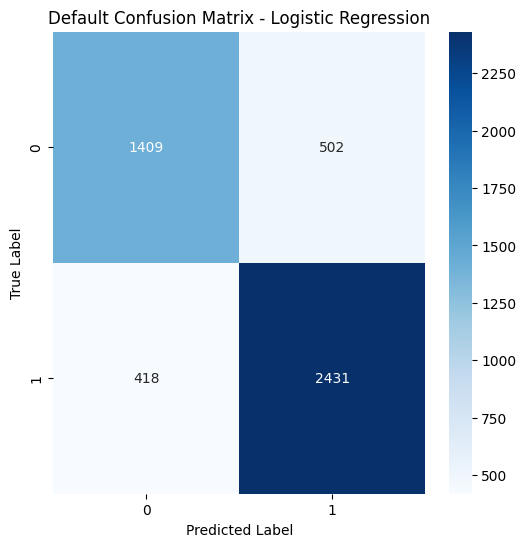

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sobral/Desktop/

Default parameters accuracy: 0.8090336134453782

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.74      0.76      1911
   Malicious       0.83      0.86      0.84      2849

    accuracy                           0.81      4760
   macro avg       0.80      0.80      0.80      4760
weighted avg       0.81      0.81      0.81      4760



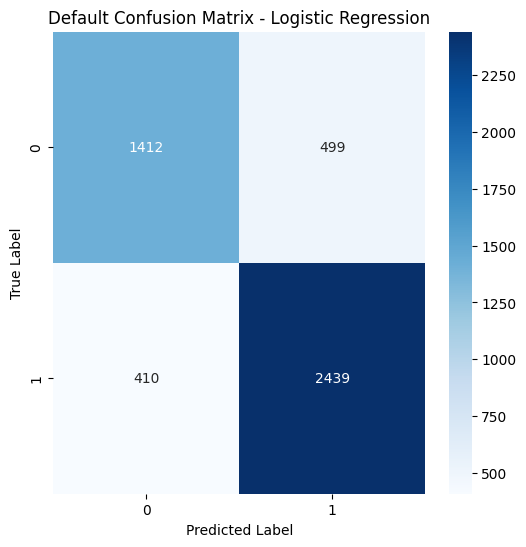


K-Nearest Neighbors Evaluation:
Default parameters accuracy: 0.9966386554621849

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



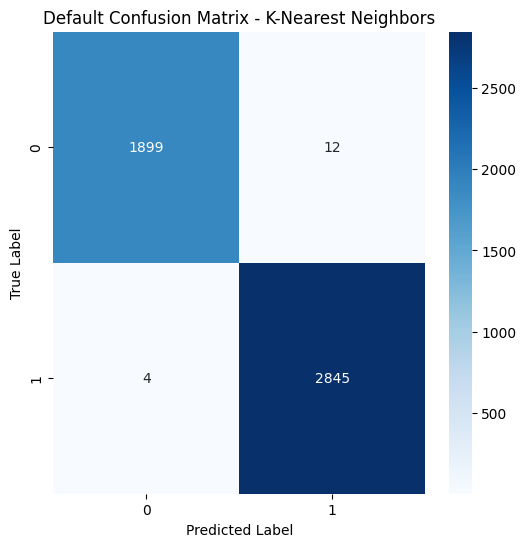

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas-project-kubernetes-attacks-detection-98491/.venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sobral/Desktop/aas

Default parameters accuracy: 0.9983193277310924

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



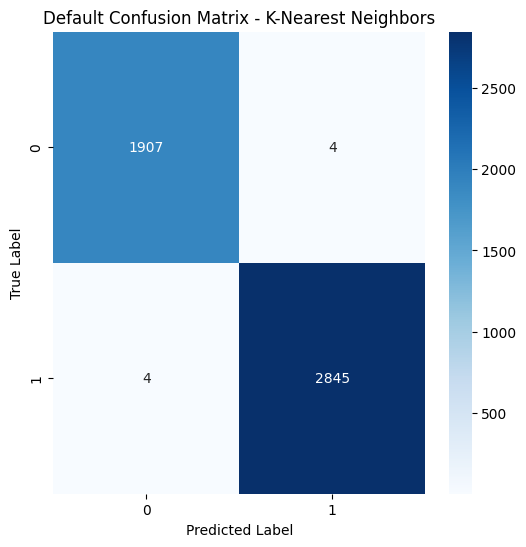


Decision Tree Evaluation:
Default parameters accuracy: 1.0

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



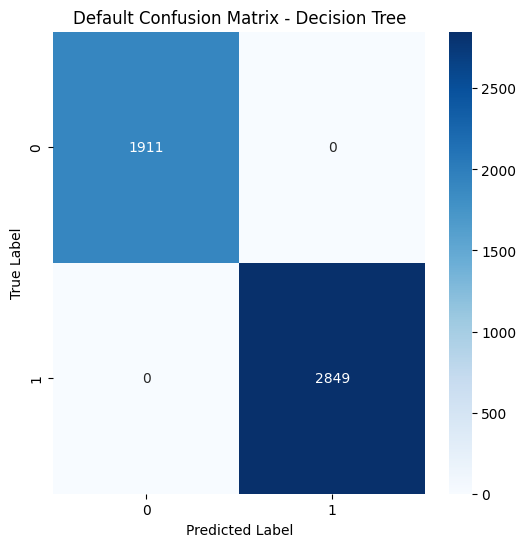

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Default parameters accuracy: 0.9993697478991597

Default Parameter Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1911
   Malicious       1.00      1.00      1.00      2849

    accuracy                           1.00      4760
   macro avg       1.00      1.00      1.00      4760
weighted avg       1.00      1.00      1.00      4760



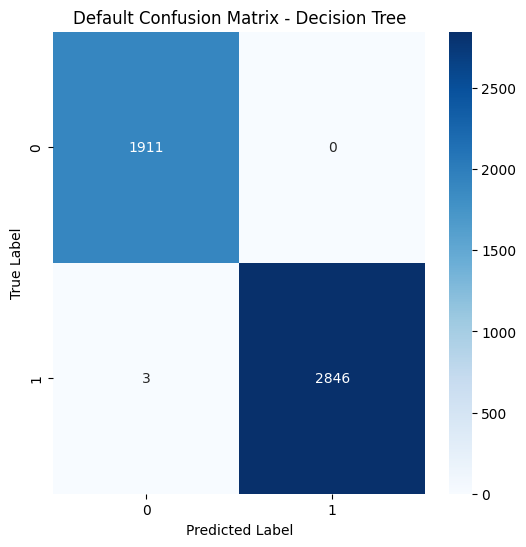

In [10]:
def conf_matrix(y_test, y_pred, name):
    cm_default = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Default Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def print_results(default_accuracy, y_pred_default, y_test):
    print(f"Default parameters accuracy: {default_accuracy}")
    print("\nDefault Parameter Classification Report:")
    print(classification_report(y_test, y_pred_default, target_names=['Benign', 'Malicious']))

for pipeline, param_grid, name in model_grids:
    print(f"\n{name} Evaluation:")

    pipeline.fit(x_train, y_train)
    y_pred_default = pipeline.predict(x_test)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    print_results(default_accuracy, y_pred_default, y_test)

    #confusion Matrix for default parameters
    conf_matrix(y_test, y_pred_default, name)

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(x_test)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    print_results(best_accuracy, y_pred_best, y_test)

    #confusion Matrix for best parameters
    conf_matrix(y_test, y_pred_best, name)

    # Save the results
    results["Model"].append(name)
    results["Default Accuracy"].append(default_accuracy)
    results["Best Accuracy"].append(best_accuracy)
    results["Best Parameters"].append(grid_search.best_params_)


### Results

In [12]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', 200)

results_df

,Model,Default Accuracy,Best Accuracy,Best Parameters
0,SVM,0.974370,0.978361,"{'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}"
1,Logistic Regression,0.806723,0.809034,"{'classifier__C': 10, 'classifier__solver': 'newton-cg'}"
2,K-Nearest Neighbors,0.996639,0.998319,"{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}"
3,Decision Tree,1.000000,0.999370,"{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1}"
